In [1]:
#импорт необходимых библиотек
#Авторы: Рукавишников Алексей, Шестаков Кирилл, Константинова Александра, Кравец Полина

import numpy as np
import pandas as pd
import os
import time
import datetime
from random import randint, seed

import seaborn as sns
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans, silhouette_score

from core_changed import Backtest, PlotPoint, IStrategy
from multiprocessing import Pool
from math import log
from datetime import datetime

In [2]:
total_path = 'C:\\Users\\Алексей\\Учеба\\ЦМФ\\Проекты\\Алготрейдинг\\Задание 6'
data_path = total_path + '\\stock_data'

In [3]:
file_list = os.listdir(data_path)

In [4]:
def fill_na_custom_long(ts, border):
    
    # функция заполенения пропущенных значений. Принимает ряд и максимальную длину куска Nan в ряде
    # заполняет найденные куски линейной интерполяцией соседних значений. Если Nan на границе ряда - не учитывает их.
    size = list(np.arange(1,border+1))


    for i in size:
        flag_list = list()
        for j in range(0,len(ts[:(-1)*i])):

            el_flag = check_el(ts, j, i)
            flag_list.append(el_flag)

        flag_list = flag_list

        for j in range(0,len(flag_list)):
            if flag_list[j] == True:
                step = (ts[j+i] - ts[j-1])/(i+1)
                for k in range(0,i):
                    ts[j+k] = np.round(ts[j-1]+step*(k+1),2)
                
                
    return ts

In [5]:
def check_el(ts, num_el, length):
    
    # функция поиска кусков Nan в ряде. Принимает ряд, номер элемента в ряде и число length последующих элементов
    # Если элемент и все length следующих элементов nan, а length+1 не Nan, возвращает True
    # В остальных возвращает False. Не оптимизирована (при вылете за индексацию списка будет падать)
    
    if ts[num_el]!=ts[num_el]:
        if ts[num_el-1]==ts[num_el-1]:
            sub_list = ts[num_el:num_el+length]
            sub_list_flag = [i!=i for i in sub_list]
            end_check = (ts[num_el+length]==ts[num_el+length])
            if all(sub_list_flag) and end_check:
                return True
            else:
                return False


        else:
            return False
    else:
        return False

In [6]:
def cacl_Nan_col(df, pr, return_Flag = True):
    # кастомная функция подсчета Nan в колонках. Возвращает список колонок для удаления (если флаг True), или 
    # пишет долю строк с Nan выше pr при флаге False
    col_Nan = pd.DataFrame(df.isnull().sum(axis = 0),columns=['Nan'])
    res = len(col_Nan[col_Nan['Nan'] > pr * len(df)])
    
    
    if return_Flag == True:
        return list(col_Nan[col_Nan['Nan'] > pr * len(df)].index)
    else:
        print('В '+str(res)+' колонках Nan больше '+str(int(pr*100))+'%')

In [7]:
def fill_na_custom(ts):
    
    # функция заполнения Nan. Если в ряде Nan одиночное (слева и справа непустые значения), заполняет средним.
    # принимает: временной ряд
    # возвращает: временной ряд с заполненными (если прошли по условию) Nan
    flag_list = [True if ((ts[i]!=ts[i]) & ((ts[i-1]==ts[i-1]) | (ts[i+1]==ts[i+1]))) else False for i in range(1,len(ts)-1)]
    flag_list = [False] + flag_list
    flag_list = flag_list + [False]
    ts = [ts[i] if flag_list[i]==False else (ts[i-1]+ts[i+1])/2  for i in range(0,len(ts))]
    
    return ts

In [8]:
def fill_na_custom_long(ts, border):
    
    # функция заполнения Nan. Если в ряде есть отрезок Nan <= border (слева и справа непустые значения), 
    # заполняет интерполяцией крайних значений.
    # принимает: временной ряд
    # возвращает: временной ряд с заполненными (если прошли по условию) Nan
    flag_list = [True if ((ts[i]!=ts[i]) & ((ts[i-1]==ts[i-1]) | (ts[i+1]==ts[i+1]))) else False for i in range(1,len(ts)-1)]
    flag_list = [False] + flag_list
    flag_list = flag_list + [False]
    ts = [ts[i] if flag_list[i]==False else (ts[i-1]+ts[i+1])/2  for i in range(0,len(ts))]
    
    return ts

In [9]:
def cacl_Nan_row(df, pr, return_Flag = True):
    # кастомная функция подсчета Nan в строках. Возвращает список строк для удаления (если флаг True), или 
    # пишет долю строк с Nan выше pr при флаге False
    row_Nan = pd.DataFrame(df.isnull().sum(axis = 1),columns=['Nan'])
    res = len(row_Nan[row_Nan['Nan'] > pr * len(df.columns)])
    
    
    if return_Flag == True:
        return list(row_Nan[row_Nan['Nan'] > pr * len(df.columns)].index)
    else:
        print('В '+str(res)+' строках Nan больше '+str(int(pr*100))+'%')

In [10]:
#объединим все в один фрейм

# total_df = pd.DataFrame()

# for i in file_list:
#     if i != '.DS_Store':
#         data = pd.read_excel(data_path+'/'+i)
#         ticker_name = i[:-4]
#         data[ticker_name] = data['close']
#         data = data[['Index',ticker_name]]

#         if len(total_df) == 0:
#             total_df = data.copy()
#         else:
#             total_df = total_df.merge(data, on = 'Index', how = 'outer')

In [11]:
total_df = pd.read_csv('china_close_total.csv')


total_df = total_df.rename({'Index':'Datetime'}, axis = 1)

In [12]:
total_df.sort_values(by='Datetime', inplace=True)
total_df = total_df.reset_index(drop=True)

##### места, где длина пропуска <=5 заменим линейной апроксимацией

In [13]:
for i in list(total_df.columns)[1:]:
    ts = list(total_df[i])
    ts = fill_na_custom_long(ts, 5)
    total_df[i] = ts

построим график зависимости числа пропусков от даты

Text(0, 0.5, 'Число Nan')

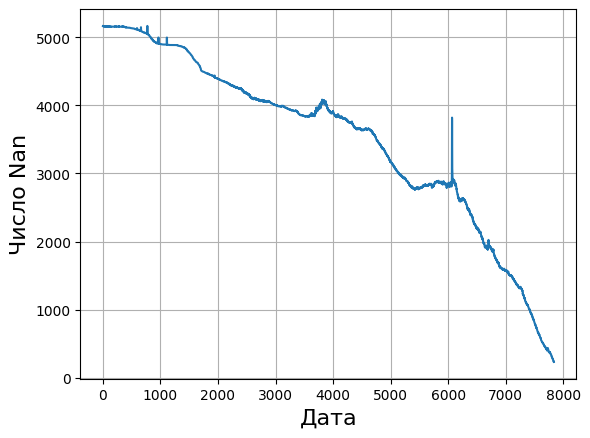

In [14]:
sub_df = pd.DataFrame(total_df.isnull().sum(axis = 1))
x = list(sub_df.index)
y = list(sub_df[0])

fig, ax = plt.subplots()
ax.plot(x,y)
plt.xlabel('Дата' , size=16)
plt.grid()
plt.ylabel('Число Nan', size=16)

In [15]:
border = 6500

In [16]:
sub_df[sub_df.index == border]

,0
6500,2188


In [17]:
total_df[total_df.index == border]['Datetime']

6500    2017-04-18 00:00:00
Name: Datetime, dtype: object

видно, что в начале очень много пропусков. Возьмем даты >= 6500 (2017-04-18 и позже)

In [18]:
total_df = total_df[total_df['Datetime']>='2017-04-18']
total_df = total_df.reset_index(drop=True)

start_date = list(total_df['Datetime'])

In [19]:
total_df

,Datetime,000001,000002,000003,000004,000005,000006,000007,000008,000009,...,871396,871553,871642,871857,871970,871981,872925,873122,873169,873223
0,2017-04-18 00:00:00,7.99,14.49,NaN,NaN,6.31,NaN,NaN,8.71,7.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-04-19 00:00:00,7.85,14.55,NaN,NaN,6.19,NaN,NaN,8.62,7.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-04-20 00:00:00,7.86,14.65,NaN,NaN,6.16,NaN,NaN,8.62,7.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-04-21 00:00:00,7.91,14.70,NaN,NaN,6.19,NaN,NaN,8.67,7.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-04-24 00:00:00,7.87,14.45,NaN,NaN,6.01,NaN,NaN,8.56,7.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,2022-10-14 00:00:00,11.53,17.02,NaN,8.55,1.72,NaN,7.94,2.27,12.63,...,7.62,3.46,6.76,8.78,9.08,14.56,16.11,11.39,6.68,3.97
1336,2022-10-17 00:00:00,11.48,16.60,NaN,8.80,1.73,NaN,7.93,2.29,12.50,...,7.60,3.51,7.03,8.86,9.15,14.57,16.03,11.53,6.90,3.92
1337,2022-10-18 00:00:00,11.48,16.38,NaN,8.83,1.74,NaN,7.92,2.40,12.82,...,7.63,3.49,6.97,8.85,9.10,14.62,15.62,13.02,7.04,4.03
1338,2022-10-19 00:00:00,11.29,16.17,NaN,8.70,1.71,NaN,7.90,2.33,12.54,...,7.63,3.49,6.81,8.85,9.05,14.21,15.76,12.45,6.78,3.94


##### посмотрим, сколько Nan по колонкам (1)

In [20]:
cacl_Nan_col(total_df, 0.1, return_Flag = False)

В 1989 колонках Nan больше 10%


In [21]:
del_col_list = cacl_Nan_col(total_df, 0.1)
total_df.drop(columns = del_col_list,axis = 1, inplace=True)

##### теперь чистим по строкам (1)

In [22]:
cacl_Nan_row(total_df, 0.1, return_Flag = False)

В 35 строках Nan больше 10%


удалим строки с Nan более 10%

In [23]:
bad_index = cacl_Nan_row(total_df, 0.1)
total_df = total_df.drop(index=bad_index)
total_df = total_df.reset_index(drop = True)

##### снова пройдемся по данным, в случаях где длина пропуска <=3, заместим средним (2)

In [24]:
for i in list(total_df.columns)[1:]:
    ts = list(total_df[i])
    ts = fill_na_custom_long(ts, 3)
    total_df[i] = ts

##### снова почистим колонки (2)

In [25]:
cacl_Nan_col(total_df, 0.05,  return_Flag = False)

В 375 колонках Nan больше 5%


In [26]:
# снова удалим колонки с Nan больше 5%
del_col_list = cacl_Nan_col(total_df, 0.05)
total_df.drop(columns = del_col_list,axis = 1, inplace=True)

##### снова почистим строки (2)

In [27]:
cacl_Nan_row(total_df, 0.05, return_Flag = False)

В 25 строках Nan больше 5%


In [28]:
# Удаляем строки с Nan более 5%
bad_index = cacl_Nan_row(total_df, 0.05)
total_df = total_df.drop(index=bad_index)
total_df = total_df.reset_index(drop = True)

Text(0, 0.5, 'Число Nan')

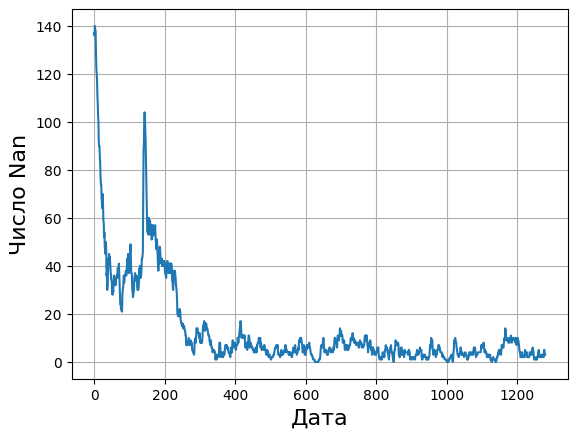

In [29]:
sub_df = pd.DataFrame(total_df.isnull().sum(axis = 1))
x = list(sub_df.index)
y = list(sub_df[0])

fig, ax = plt.subplots()
ax.plot(x,y)
plt.xlabel('Дата' , size=16)
plt.grid()
plt.ylabel('Число Nan', size=16)

##### снова пройдемся по данным, в случаях где длина пропуска <=6, заместим средним (3)

In [30]:
for i in list(total_df.columns)[1:]:
    ts = list(total_df[i])
    ts = fill_na_custom_long(ts, 6)
    total_df[i] = ts

##### и снова почистим колонки (3)

In [31]:
cacl_Nan_col(total_df, 0.02,  return_Flag = False)

В 204 колонках Nan больше 2%


In [32]:
# снова удалим колонки с Nan больше 2%
del_col_list = cacl_Nan_col(total_df, 0.02)
total_df.drop(columns = del_col_list,axis = 1, inplace=True)

##### и снова почистим строки (3)

In [33]:
cacl_Nan_row(total_df, 0.01, return_Flag = False)

В 29 строках Nan больше 1%


In [34]:
# Удаляем строки с Nan более 1%
bad_index = cacl_Nan_row(total_df, 0.01)
total_df = total_df.drop(index=bad_index)
total_df = total_df.reset_index(drop = True)

##### снова пройдемся по данным, в случаях где длина пропуска <= 6, заместим средним (4)

In [35]:
for i in list(total_df.columns)[1:]:
    ts = list(total_df[i])
    ts = fill_na_custom_long(ts, 3)
    total_df[i] = ts

##### и снова почистим колонки (4)

In [36]:
cacl_Nan_col(total_df, 0.005,  return_Flag = False)

В 462 колонках Nan больше 0%


In [37]:
# снова удалим колонки с Nan больше 0.5%
del_col_list = cacl_Nan_col(total_df, 0.005)
total_df.drop(columns = del_col_list,axis = 1, inplace=True)

проверим число Nan

Text(0, 0.5, 'Число Nan')

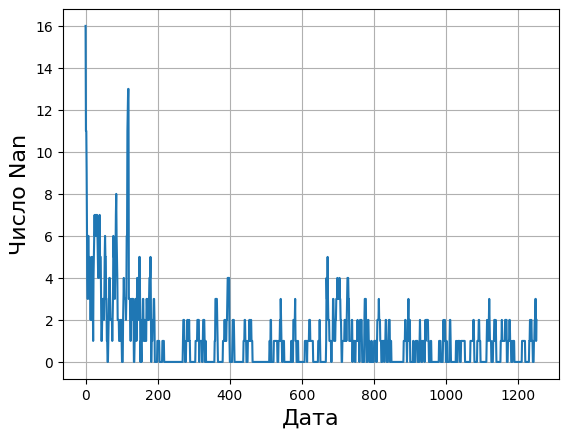

In [38]:
sub_df = pd.DataFrame(total_df.isnull().sum(axis = 1))
x = list(sub_df.index)
y = list(sub_df[0])

fig, ax = plt.subplots()
ax.plot(x,y)
plt.xlabel('Дата' , size=16)
plt.grid()
plt.ylabel('Число Nan', size=16)

##### снова пройдемся по данным, в случаях где длина пропуска <= 5, заместим линейной аппроксимацией. Остальное выкинем

In [39]:
for i in list(total_df.columns)[1:]:
    ts = list(total_df[i])
    ts = fill_na_custom_long(ts, 5)
    total_df[i] = ts

In [40]:
total_df_final = total_df.dropna()
total_df_final

,Datetime,000001,000002,000005,000009,000010,000011,000012,000014,000017,...,603978,603979,603980,603985,603987,603989,603990,603991,603993,603999
61,2017-11-08 00:00:00,11.22,22.45,4.61,6.58,6.17,17.00,6.15,13.26,7.30,...,51.07,11.57,15.34,9.41,11.19,28.54,16.11,34.77,6.59,8.87
62,2017-11-09 00:00:00,11.42,22.48,4.65,6.56,6.12,16.90,6.17,13.25,7.29,...,50.09,11.54,15.40,9.40,11.11,29.05,16.25,35.15,6.55,8.86
101,2018-01-08 00:00:00,12.05,30.80,4.37,6.15,6.20,15.83,6.58,11.04,6.32,...,42.70,10.09,13.83,8.11,7.96,28.06,16.12,27.64,6.97,7.57
102,2018-01-09 00:00:00,12.17,30.65,4.41,6.12,6.01,15.70,6.60,10.66,6.29,...,42.01,10.04,13.54,7.96,8.42,28.81,15.98,27.64,6.91,7.61
103,2018-01-10 00:00:00,12.56,30.48,4.32,6.03,5.97,15.40,6.46,10.49,6.23,...,41.65,9.86,13.24,7.78,8.25,31.87,15.72,27.04,6.88,7.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,2022-09-13 00:00:00,12.95,18.18,1.87,14.62,3.70,10.43,6.91,9.04,4.25,...,23.50,21.39,5.27,28.13,15.77,27.58,21.42,40.27,5.22,5.31
1229,2022-09-14 00:00:00,12.73,17.91,1.87,14.34,3.71,10.54,7.60,9.94,4.20,...,23.19,20.97,5.19,27.38,15.51,28.43,21.15,40.06,5.12,5.19
1240,2022-09-29 00:00:00,11.86,17.15,1.67,11.55,3.18,9.11,7.35,8.07,3.97,...,21.62,20.29,4.67,25.79,15.00,27.79,19.51,36.69,4.72,4.75
1241,2022-09-30 00:00:00,11.84,17.83,1.68,11.22,3.15,9.19,6.94,8.26,3.76,...,20.70,20.21,4.64,24.90,15.27,27.95,18.83,38.40,4.72,4.74


проверим, насколько все плохо с разрывами

In [41]:
actual_date = list(total_df_final['Datetime'])

In [42]:
y = list()

for i in start_date:
    if i in actual_date:
        y.append(1)
    else:
        y.append(0)

Text(0, 0.5, 'Есть ли он в результате')

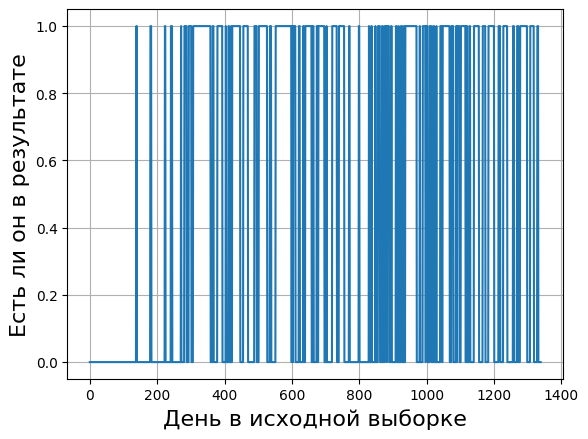

In [43]:
x = np.arange(0,len(start_date))

fig, ax = plt.subplots()
ax.plot(x,y)
plt.xlabel('День в исходной выборке' , size=16)
plt.grid()
plt.ylabel('Есть ли он в результате', size=16)

визуально, разрывы не превышают 2 месяцев (60 дней). Придется оставить так, т.к. иначе ряды станут еще короче

удалим отрицательные цены

In [55]:
good_tickers = list()

for i in list(total_df.columns)[1:]:
    ts = list(total_df[i])
    if all([i>=0 for i in ts]):
        good_tickers.append(i)

In [58]:
total_df_final = total_df_final[good_tickers]

In [59]:
total_df_final.to_csv('data_final_v1_upd.csv', index = False)